In [ ]:
  from google.colab import drive
  drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

path = "drive/MyDrive/AI VK 2025/VK AI lab/Предсказание количества просмотров рекламы/Предсказание количества просмотров рекламы/"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
history = pd.read_csv(path +'history.tsv', sep='\t', encoding='utf-8')
users = pd.read_csv(path +'users.tsv', sep='\t', encoding='utf-8')
validate = pd.read_csv(path + 'validate.tsv', sep='\t', encoding='utf-8')
validate_answers = pd.read_csv(path + 'validate_answers.tsv', sep='\t', encoding='utf-8')

validate['user_ids'] = validate['user_ids'].apply(lambda x: [int(i) for i in x.split(',')])
validate['publishers'] = validate['publishers'].apply(lambda x: [int(i) for i in x.split(',')])
history['log_cpm'] = np.log(history['cpm'])

<Axes: >

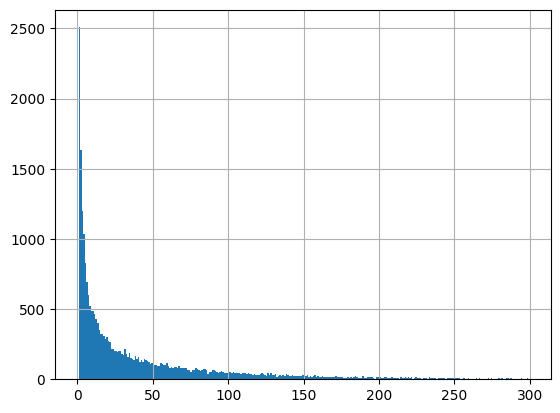

In [ ]:
history.groupby('user_id').size().reset_index(name='count')['count'].hist(bins=np.arange(0, 300))

распределение выиграшных ставок

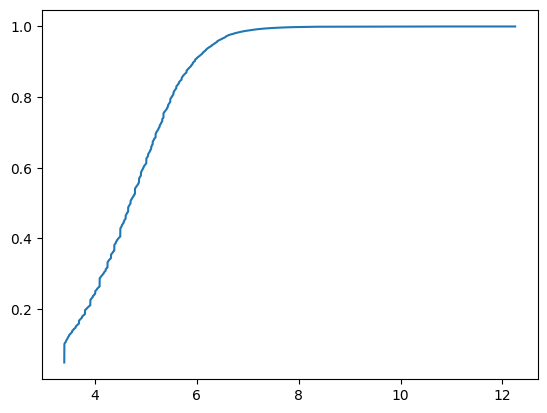

In [ ]:
import numpy as np


def calculate_modified_cdf(data):
    sorted_data = np.sort(np.array(data))
    unique_values, counts = np.unique(sorted_data, return_counts=True)
    result_probs = []
    values = []
    for i, value in enumerate(unique_values):
        less_than_prob = np.sum(sorted_data < value) / len(sorted_data)
        equal_to_prob = counts[i] / len(sorted_data)
        modified_prob = less_than_prob + 0.5 * equal_to_prob
        result_probs.append(modified_prob)
        values.append(value)

    return values, result_probs


values, result_probs = calculate_modified_cdf(np.log(history['cpm']))
plt.plot(values, result_probs)



похоже на функцию распределения нормального распределения

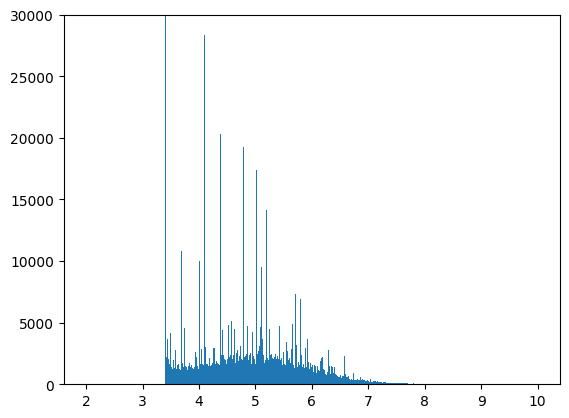

In [ ]:
plt.hist(np.log(history['cpm']), bins=np.arange(2, 10, 0.01))
plt.ylim(0, 30000)
plt.show()

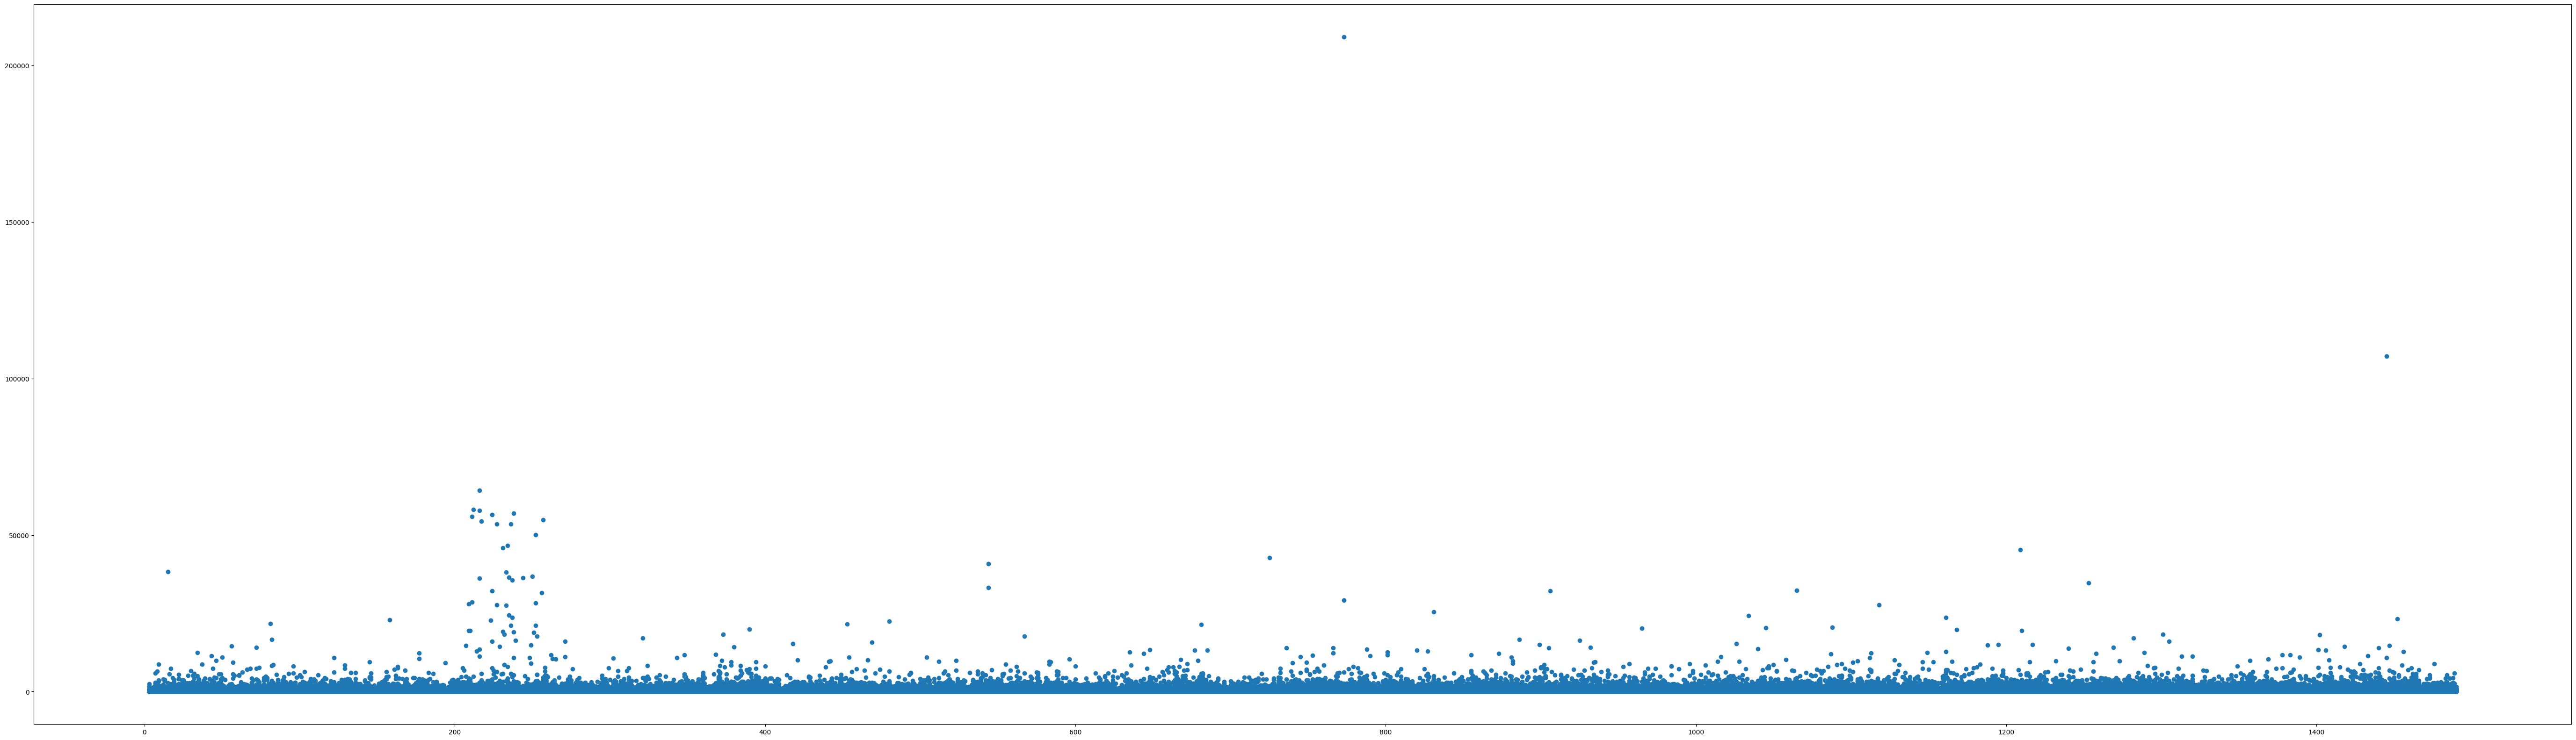

In [ ]:
plt.figure(figsize=(70, 20))
plt.scatter(history['hour'], history['cpm'])

In [ ]:
users.head()

,user_id,sex,age,city_id
0,0,2,19,0
1,1,1,0,1
2,2,2,24,2
3,3,1,20,3
4,4,2,29,4


In [ ]:

validate.shape

(1008, 6)

Тут смотрим как скореллированы at_least_one с остальными целвыми переменными

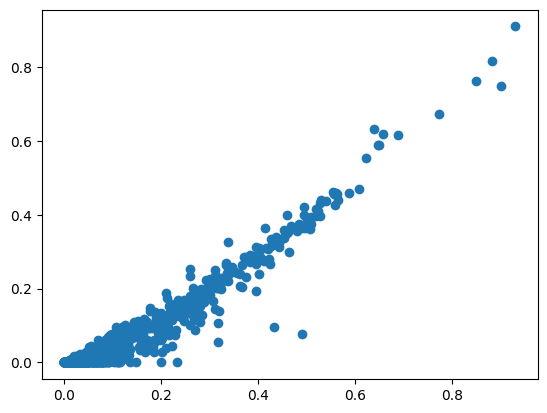

In [ ]:
plt.scatter(validate_answers['at_least_one'], validate_answers['at_least_two'])

In [ ]:
X = pd.DataFrame(
    {'hours_count': validate['hour_end'] - validate['hour_start'], 'audience_size': validate['audience_size'],
     'cpm': validate['cpm'], 'publishers_count': validate['publishers'].apply(lambda x: len(x)),
     'at_least_one': validate_answers['at_least_one']})


In [ ]:
y = validate_answers['at_least_two']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

scalar = StandardScaler()
X = scalar.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, shuffle=True)

lr = LinearRegression()
lr.fit(X_train, y_train)
print(mean_squared_error(y_test, lr.predict(X_test)))

polynomial_features = PolynomialFeatures(degree=3)  # Создаем полиномиальные признаки степени 3
X_train_poly = polynomial_features.fit_transform(X_train)
X_test_poly = polynomial_features.fit_transform(X_test)
lr.fit(X_train_poly, y_train)
print(mean_squared_error(y_test, lr.predict(X_test_poly)))

0.0009028905918440231
0.0002781632149606879


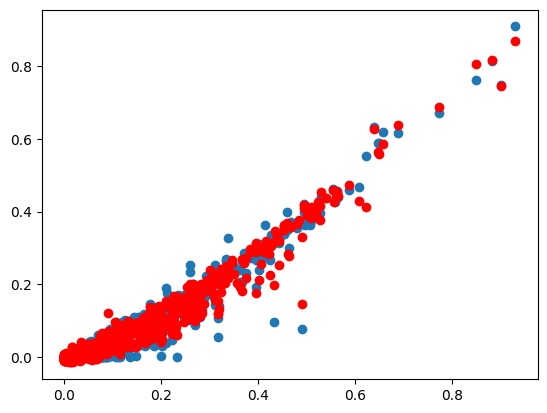

In [ ]:
plt.scatter(validate_answers['at_least_one'], validate_answers['at_least_two'])
plt.scatter(validate_answers['at_least_one'], lr.predict(polynomial_features.transform(X)), color='red')

In [ ]:
!pip install catboost

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import catboost

models = [
    ("Linear Regression", LinearRegression()),
    ("Ridge Regression", Ridge()),
    ("Lasso Regression", Lasso()),
    ("Elastic Net Regression", ElasticNet()),
    ("Decision Tree Regression", DecisionTreeRegressor()),
    ("Random Forest Regression", RandomForestRegressor(n_estimators=100, random_state=42)),
    ("Gradient Boosting Regression",
     GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),
    ("SVR", SVR(kernel='rbf', C=1.0, epsilon=0.1)),
    ("k-NN", KNeighborsRegressor(n_neighbors=5)),
    # ("MLP", MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42, max_iter=2000))
    ("CatBoost", catboost.CatBoostRegressor())
]

results = []  # Сохраняем результаты, чтобы потом их удобно сортировать или анализировать
for name, model in models:
    try:
        if name == "Random Forest Regression" or name == "Gradient Boosting Regression" or name == "SVR" or name == "MLP":
            model.fit(X_train, y_train.ravel())  # ravel() для преобразования формы y_train в 1D массив для этих моделей
        else:
            model.fit(X_train, y_train)  # Большинство моделей принимает y_train в форме (n_samples, 1)

        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results.append((name, mse, r2))

        print(f"Модель: {name}")
        print(f"  MSE: {mse:.7f}")
        print(f"  R2: {r2:.7f}")
    except Exception as e:
        print(f"Ошибка при обучении или предсказании для модели {name}: {e}")



Модель: Linear Regression
  MSE: 0.0009029
  R2: 0.9271821
Модель: Ridge Regression
  MSE: 0.0009001
  R2: 0.9274060
Модель: Lasso Regression
  MSE: 0.0123993
  R2: -0.0000006
Модель: Elastic Net Regression
  MSE: 0.0123993
  R2: -0.0000006
Модель: Decision Tree Regression
  MSE: 0.0003606
  R2: 0.9709201
Модель: Random Forest Regression
  MSE: 0.0002935
  R2: 0.9763286
Модель: Gradient Boosting Regression
  MSE: 0.0002003
  R2: 0.9838455
Модель: SVR
  MSE: 0.0038848
  R2: 0.6866934
Модель: k-NN
  MSE: 0.0009225
  R2: 0.9255967
Learning rate set to 0.037808
0:	learn: 0.1192623	total: 2.35ms	remaining: 2.35s
1:	learn: 0.1159536	total: 3.92ms	remaining: 1.95s
2:	learn: 0.1128011	total: 6.79ms	remaining: 2.26s
3:	learn: 0.1104606	total: 10.1ms	remaining: 2.52s
4:	learn: 0.1076273	total: 11.6ms	remaining: 2.31s
5:	learn: 0.1044360	total: 13ms	remaining: 2.16s
6:	learn: 0.1022158	total: 14.5ms	remaining: 2.05s
7:	learn: 0.0995822	total: 15.9ms	remaining: 1.97s
8:	learn: 0.0971004	total: 17.

Функция потерь из тз

In [ ]:
def tz_loss_function(y_true, y_pred):
  eps = 0.005
  return 100 * np.exp(np.sum(np.abs(np.log((y_pred + eps) / (y_true + eps)))) / len(y_true)) - 100

**Попробуем обучить простую модель**

In [ ]:
all_time_cpm_mean = history['log_cpm'].mean()
all_time_cpm_std = history['log_cpm'].std()

In [ ]:
pyblisher_popularity_df = history.groupby('publisher').size().reset_index(name='count').set_index('publisher').reset_index()

In [ ]:
pyblisher_popularity_df.head()

,publisher,count
0,1,692535
1,2,273037
2,3,72124
3,4,2286
4,5,7263


In [ ]:
import scipy.stats as st

X = validate.copy()
X['probability'] = st.norm.cdf(np.log(X['cpm']), all_time_cpm_mean, all_time_cpm_std)
X['duratin_hours'] = X['hour_end'] - X['hour_start']
# X['publishers_count'] = X['publishers'].apply(lambda x: len(x))
X['publisher_stat'] = X['publishers'].apply(lambda x: np.sum([pyblisher_popularity_df.iloc[id_ - 1, 1] for id_ in x]))
X.drop(columns=['hour_start', 'hour_end', 'publishers', 'user_ids', 'cpm'], inplace=True)

In [ ]:
X.head()

,audience_size,probability,duratin_hours,publisher_stat
0,1906,0.762565,95,67229
1,1380,0.863047,6,72320
2,888,0.298267,20,1048434
3,440,0.790771,82,693590
4,1476,0.817102,238,834418


In [ ]:
y = validate_answers['at_least_one']

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


scalar = StandardScaler()
pf = PolynomialFeatures(degree=4)
X = pf.fit_transform(X)
X = scalar.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle = True)


In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(mean_squared_error(y_test, y_pred))
print(tz_loss_function(y_test, y_pred))

0.005417282545253536
76.41289008548168


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.4 MB/s eta 0:00:00


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
import xgboost as xgb
models = {'gbr' : GradientBoostingRegressor(), "cat_boost" : CatBoostRegressor(verbose=False),"xgb" : xgb.XGBRegressor()}

import scipy.stats as st

X = validate.copy()
X['probability'] = st.norm.cdf(X['cpm'], all_time_cpm_mean, all_time_cpm_std)
X['duratin_hours'] = X['hour_end'] - X['hour_start']
X['publishers_count'] = X['publishers'].apply(lambda x: len(x))
X['publisher_stat'] = X['publishers'].apply(lambda x: np.sum([pyblisher_popularity_df.iloc[id_ - 1, 1] for id_ in x]))
X.drop(columns=['hour_start', 'hour_end', 'publishers', 'user_ids'], inplace=True)
scalar = StandardScaler()
X = scalar.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle = True)


for model_name, model in models.items():
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  # print(model_name, mean_squared_error(y_test, y_pred))
  print(model_name, tz_loss_function(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


gbr 83.52149270631097
cat_boost 78.01056739428668
xgb 86.06556926281274


такой момент еще, похоже что если не брать log от cmp получается лучше...

mse в 0.006 лучшая, но тут какой-то стремный разброс, если еще перезапускать код, сильно может поменяться резутьтат

**Попробуем обучить модель которая для каждого пользователя считает его распределение**

In [ ]:
users_count_shows = history.groupby('user_id').size().reset_index(name='count')


In [ ]:
eps = 0.005
users = pd.read_csv(path +'users.tsv', sep='\t', encoding='utf-8')
user_distributions = history.groupby('user_id')['log_cpm'].agg(['mean', 'std']).reset_index().set_index('user_id')[['mean', 'std']].reset_index()
users_count_shows = history.groupby('user_id').size().reset_index(name='count')
users = users.merge(users_count_shows, on='user_id', how='left').fillna(0)
users = users.merge(user_distributions, on='user_id', how='left').fillna(eps)

In [ ]:
history

,hour,cpm,publisher,user_id,log_cpm
0,10,30.00,1,15661,3.401197
1,8,41.26,1,8444,3.719894
2,7,360.00,1,15821,5.886104
3,18,370.00,1,21530,5.913503
4,8,195.00,2,22148,5.273000
...,...,...,...,...,...
1147852,382,45.00,1,7871,3.806662
1147853,360,33.35,1,7992,3.507058
1147854,381,205.00,1,21516,5.323010
1147855,383,37.50,1,8224,3.624341


In [ ]:
STATS_DURATION = history['hour'].max() - history['hour'].min()

In [ ]:

users

,user_id,sex,age,city_id
0,0,2,19,0
1,1,1,0,1
2,2,2,24,2
3,3,1,20,3
4,4,2,29,4
...,...,...,...,...
27764,27764,1,38,295
27765,27765,2,30,79
27766,27766,2,21,1953
27767,27767,2,17,0


In [ ]:
import scipy.stats as st

def calculate_user_sum_probability(row):
  eps = 1e-6
  p_win_vector = st.norm.cdf(np.array([np.log(row['cpm'])] * row['audience_size']),
                     users[users['user_id'].isin(row['user_ids'])]['mean'] + eps,
                     users[users['user_id'].isin(row['user_ids'])]['std'] + eps) # может тут без копирования можно не писать дважды users[users['user_id'] in row['user_ids']]?

  count_auctions = [(users.iloc[user_]['count'] / STATS_DURATION * row['duratin_hours']) for user_ in row['user_ids']]
  return np.sum(np.nan_to_num(1 - (1 - p_win_vector)**count_auctions))



In [ ]:
X = validate.copy()

X['duratin_hours'] = X['hour_end'] - X['hour_start']
X['sum_user_probability'] = X.apply(calculate_user_sum_probability, axis=1)
X['publisher_stat'] = X['publishers'].apply(lambda x: np.sum([pyblisher_popularity_df.iloc[id_ - 1, 1] for id_ in x]))
X.drop(columns=['hour_start', 'hour_end', 'publishers', 'user_ids'], inplace=True)

/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2071: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2071: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [ ]:
tz_loss_function(y, np.array(X['sum_user_probability'] / X['audience_size']))

367.2321303653627

In [ ]:
y = validate_answers['at_least_one']

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


scalar = StandardScaler()
pf = PolynomialFeatures(degree=4)
X_new = pf.fit_transform(X)
X_new = scalar.fit_transform(X_new)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.25, shuffle = True)


In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(tz_loss_function(y_test, y_pred))
lr.coef_

49.841133598214554


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


array([ 1.34305323e-12, -1.51935160e-01, -1.50386211e-01, -1.69789040e-01,
        2.99356634e-01, -4.22911885e-02,  3.85240365e-01,  7.05891496e-02,
        9.07425303e-02, -9.01748780e-02,  1.23204857e-01,  6.30156894e-01,
        2.09538273e-01, -1.45725431e+00, -4.38060585e-02,  3.86467196e-01,
       -1.25401112e-01,  2.55848155e-01,  3.03264235e-01,  2.67375869e-01,
        7.46523175e-02, -4.46052049e-01,  2.75077291e-02,  1.04100831e-02,
        1.97094516e-02, -1.49504015e-01,  8.38705737e-02,  9.49938121e-02,
       -1.27444090e-01, -1.94446474e-01, -2.31213224e-01, -3.44439481e-02,
       -9.87519850e-02, -2.00630314e-03,  2.38375293e-01, -6.52706686e-02,
       -1.20937926e+00,  9.22695885e-02,  2.89817024e+00,  4.75314492e-01,
       -3.98123477e-01, -1.28173116e-01, -6.52469688e-01, -1.70702472e+00,
       -7.83614200e-01, -2.44298042e-01, -3.82765036e-01,  5.20099531e-01,
       -2.39129789e-01, -2.69178001e-01,  5.49455990e-01,  1.58874524e-02,
        8.19517205e-01,  

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

models = {
    'linear_regression': LinearRegression(),
    'ridge': Ridge(),
    'lasso': Lasso(),
    'elastic_net': ElasticNet(),
    'knn': KNeighborsRegressor(),
    'decision_tree': DecisionTreeRegressor(),
    'random_forest': RandomForestRegressor(),
    'extra_trees': ExtraTreesRegressor(),
    'gbr': GradientBoostingRegressor(),
    'xgb': XGBRegressor(),
    'cat_boost': CatBoostRegressor(verbose=False), # verbose=False чтобы не забивал вывод
    'svr': SVR()
    #'mlp': MLPRegressor() # MLPRegressor может потребовать нормализации данных и настройки
}

import scipy.stats as st

scalar = StandardScaler()
X_new = scalar.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.25, shuffle = True)


for model_name, model in models.items():
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  # print(model_name, mean_squared_error(y_test, y_pred))
  print(model_name, tz_loss_function(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


linear_regression 82.85706930656832
ridge 82.81453423610736
lasso 248.20986728185846
elastic_net 248.20986728185846
knn 73.0028037198058
decision_tree 76.06697710352466
random_forest 57.02217702392733
extra_trees 55.396237308855746
gbr 59.43923128848513


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


xgb 63.44709407990038
cat_boost 53.089550258851176
svr 98.3863885086106


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


выбили точность в 2%

Идея: считать распределение не по пользователям а по площадкам, чтобы избежать маленьких чисел

In [ ]:
rrr = history.groupby('user_id').size().reset_index(name='count')
rrr[rrr['count'] < 5].shape, rrr.shape

((6381, 2), (25536, 2))

*Проблема: много пользователей которые почти не смотрят рекламу. Распределение у них - мусор*

*Посмотрим на распределения по publishers*

In [ ]:
len(history['publisher'].unique())

21

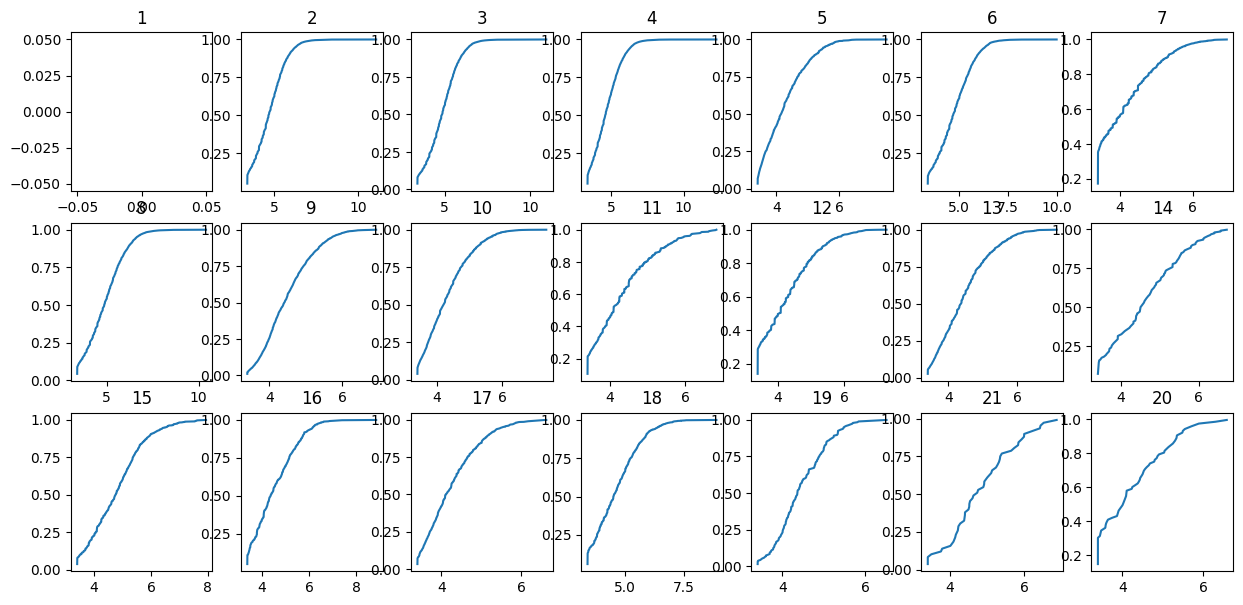

In [ ]:
fig, axes = plt.subplots(3, 7, figsize=(15, 7))
for i, pub in enumerate(history['publisher'].unique()):
  values, result_probs = calculate_modified_cdf(history[history['publisher'] == i]['log_cpm'])
  axes[i//7, i % 7].plot(values, result_probs)
  axes[i//7, i % 7].set_title(pub)

сомнительные

In [ ]:
publisher_distributions = history.groupby('publisher')['log_cpm'].agg(['mean', 'std']).reset_index().set_index('publisher')[['mean', 'std']].reset_index()
publishers_count_shows = history.groupby('publisher').size().reset_index(name='count')
publisher_distributions = publisher_distributions.merge(publishers_count_shows, on='publisher', how='left').fillna(0)
publisher_distributions
publisher_distributions.sort_values(by='count', ascending=False)


,publisher,mean,std,count
0,1,4.703713,0.907460,692535
1,2,4.845452,0.911973,273037
2,3,4.693292,0.953915,72124
6,7,4.906801,1.017331,66134
8,9,4.305042,0.700213,10165
4,5,4.736213,0.920884,7263
5,6,4.084524,0.787778,5935
9,10,4.264307,0.825563,4232
10,11,4.200057,0.805440,4028
7,8,4.495052,0.672008,3625


не такие уж и похожие

сформируем X

In [ ]:

import scipy.stats as st

def calculate_sum_publisher_probability(row):
  p_win_vector = st.norm.cdf(np.array([np.log(row['cpm'])] * len(row['publishers'])),
                     publisher_distributions[publisher_distributions['publisher'].isin(row['publishers'])]['mean'],
                     publisher_distributions[publisher_distributions['publisher'].isin(row['publishers'])]['std']) # может тут без копирования можно не писать дважды users[users['user_id'] in row['user_ids']]?

  count_auctions = [(publisher_distributions.iloc[pub_ - 1]['count'] / STATS_DURATION * row['duratin_hours']) for pub_ in row['publishers']]
  return np.sum(np.nan_to_num(1 - (1 - p_win_vector)**count_auctions))



In [ ]:
X = validate.copy()

X['duratin_hours'] = X['hour_end'] - X['hour_start']
X['sum_publisher_probability'] = X.apply(calculate_sum_publisher_probability, axis=1)
X.drop(columns=['hour_start', 'hour_end', 'publishers', 'user_ids'], inplace=True)

In [ ]:
X

,cpm,audience_size,duratin_hours,sum_publisher_probability
0,220.0,1906,95,2.000000
1,312.0,1380,6,1.959497
2,70.0,888,20,5.185026
3,240.0,440,82,2.000000
4,262.0,1476,238,4.000000
...,...,...,...,...
1003,127.0,368,59,5.000000
1004,90.0,484,4,1.067574
1005,122.0,704,5,2.000000
1006,138.0,1210,237,3.000000


In [ ]:
scalar = StandardScaler()
pf = PolynomialFeatures(degree=4)
X_new = pf.fit_transform(X)
X_new = scalar.fit_transform(X_new)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.25, shuffle = True)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(mean_squared_error(y_test, y_pred))
print(tz_loss_function(y_test, y_pred))

0.0114867729149208
149.40856205610302


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

models = {
    'linear_regression': LinearRegression(),
    'ridge': Ridge(),
    'lasso': Lasso(),
    'elastic_net': ElasticNet(),
    'knn': KNeighborsRegressor(),
    'decision_tree': DecisionTreeRegressor(),
    'random_forest': RandomForestRegressor(),
    'extra_trees': ExtraTreesRegressor(),
    'gbr': GradientBoostingRegressor(),
    'xgb': XGBRegressor(),
    'cat_boost': CatBoostRegressor(verbose=False), # verbose=False чтобы не забивал вывод
    'svr': SVR()
    #'mlp': MLPRegressor() # MLPRegressor может потребовать нормализации данных и настройки
}

import scipy.stats as st

scalar = StandardScaler()

y = validate_answers['at_least_one']
X_new = scalar.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.25, shuffle = True)


for model_name, model in models.items():
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  # print(model_name, mean_squared_error(y_test, y_pred))
  print(model_name, tz_loss_function(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


linear_regression 136.19814380682217
ridge 136.15328358548285
lasso 213.83631373191406
elastic_net 213.83631373191406
knn 141.71714570316985
decision_tree 176.69258107263516
random_forest 125.16191173079196
extra_trees 118.49709707485903
gbr 124.6868858947208


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


xgb 136.58130778152415
cat_boost 128.68525248236676
svr 172.5787494087288


как-то не очень

In [ ]:

val

,cpm,hour_start,hour_end,publishers,audience_size,user_ids
0,220.0,1058,1153,"7,17",1906,"[12, 44, 46, 50, 58, 71, 93, 122, 134, 143, 17..."
1,312.0,1295,1301,"3,18",1380,"[29, 81, 98, 102, 165, 167, 195, 205, 218, 231..."
2,70.0,1229,1249,"1,2,3,9,15,21",888,"[12, 23, 25, 29, 45, 85, 92, 124, 156, 190, 27..."
3,240.0,1295,1377,"1,14",440,"[44, 122, 187, 209, 242, 255, 312, 345, 382, 4..."
4,262.0,752,990,"1,3,7,8",1476,"[15, 24, 30, 43, 50, 53, 96, 105, 159, 168, 18..."
...,...,...,...,...,...,...
1003,127.0,1095,1154,"2,7,12,15,16",368,"[38, 50, 143, 237, 456, 649, 653, 698, 881, 89..."
1004,90.0,1052,1056,"2,21",484,"[1, 4, 61, 212, 230, 348, 356, 372, 429, 431, ..."
1005,122.0,1058,1063,"2,5",704,"[1, 23, 29, 104, 136, 176, 201, 206, 250, 269,..."
1006,138.0,932,1169,"1,2,7",1210,"[67, 73, 80, 146, 182, 202, 212, 254, 307, 377..."


In [ ]:

tz_loss_function(np.array(y), np.aans)

126.07406486676757

А если совместить эти две вероятности

In [ ]:

validate

,cpm,hour_start,hour_end,publishers,audience_size,user_ids
0,220.0,1058,1153,"[7, 17]",1906,"[12, 44, 46, 50, 58, 71, 93, 122, 134, 143, 17..."
1,312.0,1295,1301,"[3, 18]",1380,"[29, 81, 98, 102, 165, 167, 195, 205, 218, 231..."
2,70.0,1229,1249,"[1, 2, 3, 9, 15, 21]",888,"[12, 23, 25, 29, 45, 85, 92, 124, 156, 190, 27..."
3,240.0,1295,1377,"[1, 14]",440,"[44, 122, 187, 209, 242, 255, 312, 345, 382, 4..."
4,262.0,752,990,"[1, 3, 7, 8]",1476,"[15, 24, 30, 43, 50, 53, 96, 105, 159, 168, 18..."
...,...,...,...,...,...,...
1003,127.0,1095,1154,"[2, 7, 12, 15, 16]",368,"[38, 50, 143, 237, 456, 649, 653, 698, 881, 89..."
1004,90.0,1052,1056,"[2, 21]",484,"[1, 4, 61, 212, 230, 348, 356, 372, 429, 431, ..."
1005,122.0,1058,1063,"[2, 5]",704,"[1, 23, 29, 104, 136, 176, 201, 206, 250, 269,..."
1006,138.0,932,1169,"[1, 2, 7]",1210,"[67, 73, 80, 146, 182, 202, 212, 254, 307, 377..."


In [ ]:
import scipy.stats as st

X = validate.copy()
X['duratin_hours'] = X['hour_end'] - X['hour_start']
X['sum_user_probability'] = X.apply(calculate_user_sum_probability, axis=1)
X['sum_publisher_probability'] = X.apply(calculate_sum_publisher_probability, axis=1)
X['probability'] = st.norm.cdf(np.log(X['cpm']), all_time_cpm_mean, all_time_cpm_std)
X['publisher_stat'] = X['publishers'].apply(lambda x: np.sum([pyblisher_popularity_df.iloc[id_ - 1, 1] for id_ in x]))
X['alex_ans'] = ans
X.drop(columns=['hour_start', 'hour_end', 'user_ids'], inplace=True)


/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2071: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2071: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [ ]:
X.drop(columns = ['publishers'], inplace =True)

In [ ]:
X.head()

,cpm,audience_size,duratin_hours,sum_user_probability,sum_publisher_probability,probability,publisher_stat,alex_ans
0,220.0,1906,95,1155.023067,2.000000,0.762565,67229,0.196574
1,312.0,1380,6,891.321801,1.959497,0.863047,72320,0.083986
2,70.0,888,20,154.490031,5.185026,0.298267,1048434,0.153417
3,240.0,440,82,261.050606,2.000000,0.790771,693590,0.484608
4,262.0,1476,238,974.875740,4.000000,0.817102,834418,0.523202


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

models = {
    'linear_regression': LinearRegression(),
    'ridge': Ridge(),
    'lasso': Lasso(),
    'elastic_net': ElasticNet(),
    'knn': KNeighborsRegressor(),
    'decision_tree': DecisionTreeRegressor(),
    'random_forest': RandomForestRegressor(),
    'extra_trees': ExtraTreesRegressor(),
    'gbr': GradientBoostingRegressor(),
    'xgb': XGBRegressor(),
    'cat_boost': CatBoostRegressor(verbose=False), # verbose=False чтобы не забивал вывод
    'svr': SVR()
    #'mlp': MLPRegressor() # MLPRegressor может потребовать нормализации данных и настройки
}

import scipy.stats as st

scalar = StandardScaler()

y = validate_answers['at_least_one']
X_new = scalar.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.25, shuffle = True)


for model_name, model in models.items():
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  # print(model_name, mean_squared_error(y_test, y_pred))
  print(model_name, tz_loss_function(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


linear_regression 57.548377739226396
ridge 57.01954912345758
lasso 277.51098804783027
elastic_net 277.51098804783027
knn 55.659471233531974
decision_tree 35.080609566851166
random_forest 27.829314642977778
extra_trees 27.5806032844895


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


gbr 29.29142290596664
xgb 29.705011305193608
cat_boost 30.556080122294134
svr 143.11146338861053


***ЕЩЕ НЕМНОГО EDA***

<Axes: >

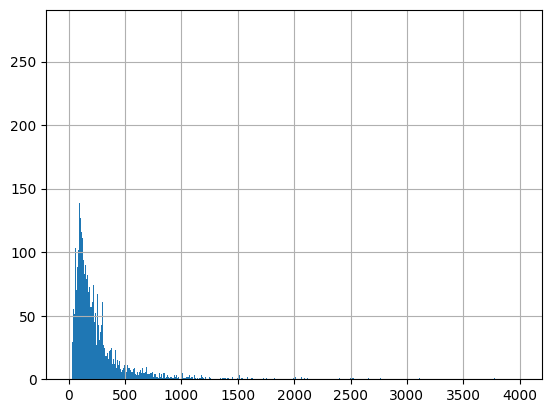

In [ ]:
history.groupby('user_id').aggregate({'cpm': 'mean'}).reset_index().sort_values(by='cpm', ascending=False)['cpm'].hist(bins=np.arange(0, 4000))

In [ ]:
history['hour_mod_24'] = history['hour'] % 24
hours24 = history.groupby('hour_mod_24')['cpm'].agg(["mean", "count", "std"]).reset_index()

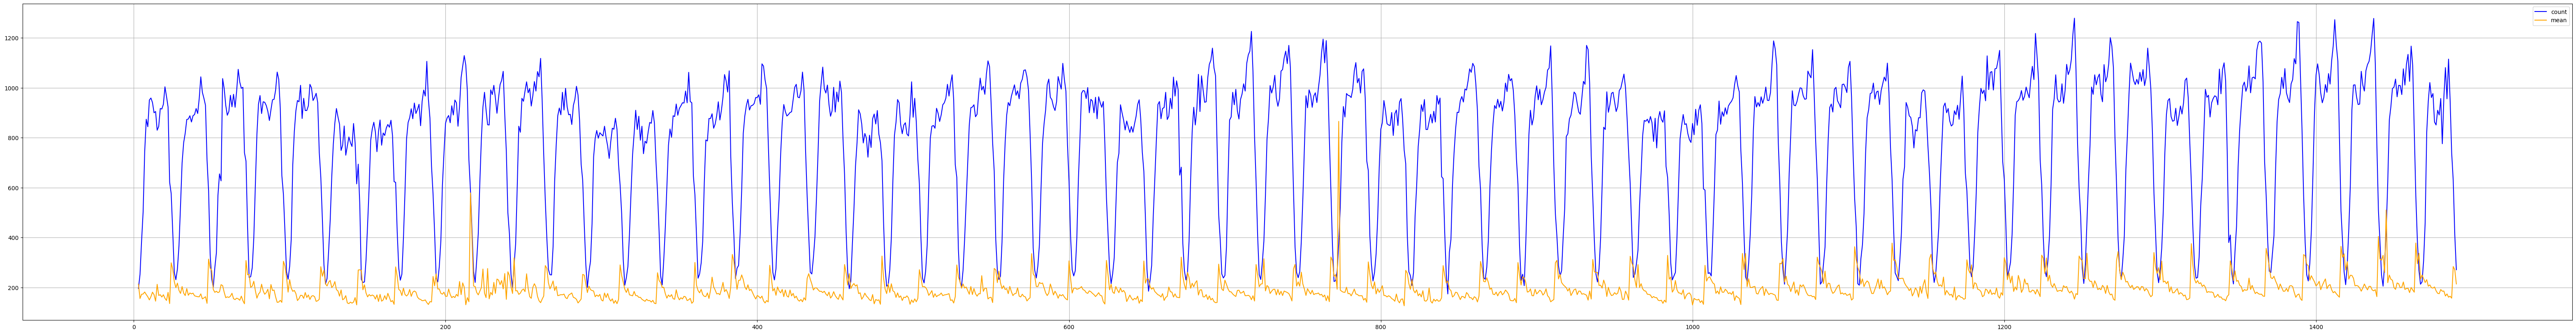

In [ ]:
count_ = history.groupby('hour').agg({'user_id': 'count', 'cpm' : 'mean'}).reset_index()['user_id']
meann = history.groupby('hour').agg({'user_id': 'count', 'cpm' : 'mean'}).reset_index()['cpm']
plt.figure(figsize=(80, 10))
plt.plot(np.arange(3, 1491), count_, label='count', color = 'blue')
plt.plot(np.arange(3, 1491), meann, label='mean', color = 'orange')
plt.legend()
plt.grid(True)

[Text(0, 0, '0'),
 Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '3'),
 Text(4, 0, '4'),
 Text(5, 0, '5'),
 Text(6, 0, '6'),
 Text(7, 0, '7'),
 Text(8, 0, '8'),
 Text(9, 0, '9'),
 Text(10, 0, '10'),
 Text(11, 0, '11'),
 Text(12, 0, '12'),
 Text(13, 0, '13'),
 Text(14, 0, '14'),
 Text(15, 0, '15'),
 Text(16, 0, '16'),
 Text(17, 0, '17'),
 Text(18, 0, '18'),
 Text(19, 0, '19'),
 Text(20, 0, '20'),
 Text(21, 0, '21'),
 Text(22, 0, '22'),
 Text(23, 0, '23')]

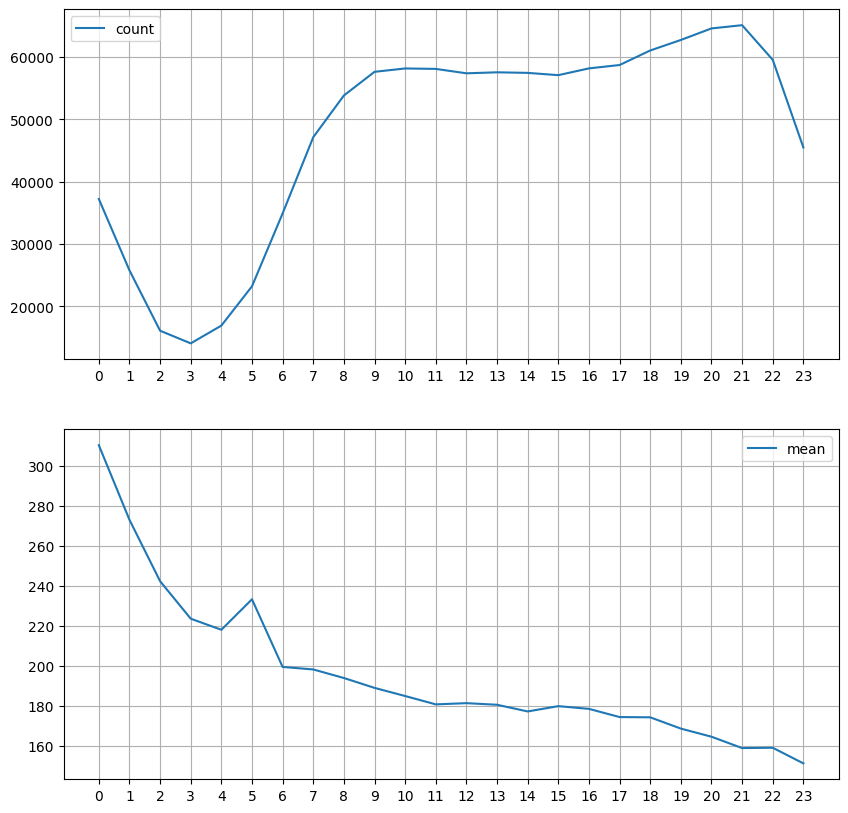

In [ ]:
fig, axis = plt.subplots(2, 1, figsize=(10, 10))
axis[0].plot(np.arange(0, 24), hours24['count'], label = 'count', )
axis[0].legend()
axis[0].grid(True)  # Добавляем сетку
axis[0].set_xticks(np.arange(0, 24))
axis[0].set_xticklabels(np.arange(0, 24)) # Добавляем подписи к x
axis[1].plot(np.arange(0, 24), hours24['mean'], label='mean')
axis[1].legend()
axis[1].grid(True)  # Добавляем сетку
axis[1].set_xticks(np.arange(0, 24))
axis[1].set_xticklabels(np.arange(0, 24)) # Добавляем подписи к x


судя по всему отсчет все-таки с 00.00
тем не менее, не ясно как это использовать, но можно оценить млотность числа аукционов в целом

**ИДЕЯ ДЛЯ КАЖДОГО USER ХРАНИМ STD И MEAN ДЛЯ КАЖДОГО СЕРВИСА**

In [ ]:
users = pd.read_csv(path +'users.tsv', sep='\t', encoding='utf-8')
user_distributions = history.groupby('user_id')['log_cpm'].agg(['mean', 'std']).reset_index().set_index('user_id')[['mean', 'std']].reset_index()
users_count_shows = history.groupby('user_id').size().reset_index(name='count')
users = users.merge(users_count_shows, on='user_id', how='left').fillna(0)
users = users.merge(user_distributions, on='user_id', how='left').fillna(eps)
users

,user_id,sex,age,city_id,count,mean,std
0,0,2,19,0,2.0,7.396968,0.997471
1,1,1,0,1,82.0,4.578372,0.632857
2,2,2,24,2,0.0,0.005000,0.005000
3,3,1,20,3,8.0,5.836829,0.407330
4,4,2,29,4,132.0,3.662286,0.447654
...,...,...,...,...,...,...,...
27764,27764,1,38,295,43.0,5.158550,0.593668
27765,27765,2,30,79,79.0,4.714108,0.723325
27766,27766,2,21,1953,54.0,4.897223,0.543364
27767,27767,2,17,0,1.0,4.968980,0.005000


Давайте посмотрим отличаются ли распределения цен для одного user в разных сервисах. Таблица в mean и std содержит стандартные отклонения mean и std соответственно по разным сервисам

In [ ]:
history.groupby(by=['user_id', 'publisher'])['cpm'].agg(['count', 'mean', 'std']).reset_index().fillna(0).sort_values('count', ascending=False).columns#.groupby('user_id').agg({'mean' : 'std', 'std': 'std', 'count': 'sum', }).reset_index().fillna(0).sort_values(by='count', ascending=False)

Index(['user_id', 'publisher', 'count', 'mean', 'std'], dtype='object')

In [ ]:
history[history['user_id'] == 5936].groupby(by=['user_id', 'publisher'])['cpm'].agg(['count', 'mean', 'std', 'min', 'max']).reset_index().fillna(0)

,user_id,publisher,count,mean,std,min,max
0,5936,3,847,329.097166,537.906325,30.0,9466.38
1,5936,8,37,130.401081,137.428367,30.0,597.33


In [ ]:
X = validate.copy()

X['duratin_hours'] = X['hour_end'] - X['hour_start']
X['sum_user_probability'] = X.apply(calculate_user_sum_probability, axis=1)
# X['publishers_count'] = X['publishers'].apply(lambda x: len(x))
X['publisher_stat'] = X['publishers'].apply(lambda x: np.sum([pyblisher_popularity_df.iloc[id_ - 1, 1] for id_ in x]))
X.drop(columns=['hour_start', 'hour_end', 'publishers', 'user_ids'], inplace=True)

/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2071: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2071: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


Можно для каждого user хранить по каждой платформе mean std count (да, дофига). Если count маленький(<20) то хранить mean std по этой площадке. Ответ считать как раньше но еще суммировать по площадкам

TODO: посмотреть есть ли у пользователей св-во зависать на разных площадках чаще в определенное время, или это все равно